# 06b: Transformer Baesd Modelling: PatchTSTForClassification (V2)

## Overview

The goal of this notebook is to develop a model that can accurately predict in-hospital mortality for patients in the Intensive Care Unit (ICU). This is a critical task in healthcare, as it can help clinicians identify high-risk patients and provide them with more intensive care.

This notebook applies a transformer-based model, PatchTSTForClassification, to perform time-series classification for predicting ICU mortality The data used in this notebook is from the PhysioNet Challenge 2012, which contains a large dataset of ICU patient data. The data includes both static features (e.g., age, gender, and ICU type) and dynamic features (e.g., vital signs, lab results, and medications).

This notebook will explore three different models:

1.  A baseline model with a simple configuration.
2.  A custom-configured model with more layers, attention heads, and dropout.
3.  A model with hyperparameters tuned using Optuna.

The performance of each model will be evaluated using a variety of metrics, including AUROC, accuracy, precision, recall, and F1-score. The best model will then be interpreted using SHAP to understand which features are most important for predicting ICU mortality.

## 1. Import Necessary Libraries

This section is crucial for setting up the environment. It imports a range of libraries essential for data manipulation (Pandas, NumPy), deep learning (PyTorch, Transformers), hyperparameter optimization (Optuna), model interpretability (SHAP), and visualization (Matplotlib, Seaborn). Additionally, it includes standard Python libraries for file and system operations, ensuring all necessary tools are available for building and evaluating the transformer based time-series classification model.

In [ ]:
%pip install optuna shap
%pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [ ]:
import sys
import os
import time
import torch
import optuna
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from transformers import PatchTSTConfig, PatchTSTForClassification

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Mount Google Drive

This section mounts the Google Drive to access files directly within the Colab environment.

In [ ]:
from google.colab import drive

# Mount Google drive
drive.mount('/content/drive')

# Base file path
basePath = 'drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject'

Mounted at /content/drive


## 3. Load Transformer Feature Data

This section loads the pre-processed data that will be used to train and evaluate the model. It loads the static and dynamic data, along with their corresponding attention masks, into separate Pandas DataFrames and then the static and dynamic dataframes are merged to create a single, combined dataframe.

In [ ]:
# Define the directory where feature files are saved
features_dir = os.path.join(basePath, 'data', 'features')

# Note: use below code if running in the local machine
# static_data_cleaned_file_path = r'../data/features/transformer_static_data_v2.csv'
# static_attention_mask_file_path = r'../data/features/transformer_static_attention_mask_v2.csv'
# patch_level_file_path = r'../data/features/transformer_dynamic_data_v2.csv'
# dynamic_attention_mask_file_path = r'../data/features/transformer_dynamic_attention_mask_v2.csv'

# Define file paths for each dataframe
static_data_cleaned_file_path = os.path.join(features_dir, 'transformer_static_data_v2.csv')
static_attention_mask_file_path = os.path.join(features_dir, 'transformer_static_attention_mask_v2.csv')
patch_level_file_path = os.path.join(features_dir, 'transformer_dynamic_data_v2.csv')
dynamic_attention_mask_file_path = os.path.join(features_dir, 'transformer_dynamic_attention_mask_v2.csv')

# Load the static and dynamic data into pandas DataFrames
transformer_static_data_df = pd.read_csv(static_data_cleaned_file_path)
transformer_static_attention_mask_df = pd.read_csv(static_attention_mask_file_path)
transformer_dynamic_data_df = pd.read_csv(patch_level_file_path)
transformer_dynamic_attention_mask_df = pd.read_csv(dynamic_attention_mask_file_path)

# Print the shape of each DataFrame to verify that the data has been loaded correctly
print("Static Data Shape:", transformer_static_data_df.shape)
print("Static Attention Mask Shape:", transformer_static_attention_mask_df.shape)
print("Dynamic Data Shape:", transformer_dynamic_data_df.shape)
print("Dynamic Attention Mask Shape:", transformer_dynamic_attention_mask_df.shape)

Static Data Shape: (4000, 5)
Static Attention Mask Shape: (4000, 5)
Dynamic Data Shape: (191856, 20)
Dynamic Attention Mask Shape: (191856, 20)


In [ ]:
# Merge static into each dynamic record using a left merge on 'RecordID'
final_combined_df = pd.merge(transformer_dynamic_data_df, transformer_static_data_df, on='RecordID', how='left')

# Display first few rows for the combined DataFrame
final_combined_df.head()

,RecordID,TimeBin,HCT,MechVent,NIDiasABP,NIMAP,NISysABP,RespRate,Urine,pH,...,RespQuotient,Temp_HR,GCS_MAP,HR_bin_enc,MAP_bin_enc,GCS_bin_enc,Gender,ICUType,In-hospital_death,AgeBMI_token_encoded
0,132539,0-60,0.415878,1.0,0.330632,1.115615,1.523818,-0.062473,1.314870,-0.01841,...,-0.148224,-0.253415,0.136129,1.0,2.0,0.0,0,4,0,17
1,132539,60-120,0.415878,1.0,0.366022,0.789919,0.887245,-0.405697,-0.384400,-0.01841,...,-0.148224,-0.728439,0.136129,0.0,2.0,0.0,0,4,0,17
2,132539,120-180,0.415878,1.0,-0.341788,-0.001107,0.293111,-0.062473,-0.128596,-0.01841,...,-0.148224,-0.667225,0.136129,1.0,2.0,0.0,0,4,0,17
3,132539,180-240,0.415878,1.0,-0.341788,-0.105833,0.102140,0.109139,-0.018966,-0.01841,...,-0.148224,-0.463014,0.136129,1.0,2.0,0.0,0,4,0,17
4,132539,240-300,0.415878,1.0,-0.341788,-0.210558,-0.088832,0.280751,-0.329585,-0.01841,...,-0.148224,-0.431759,0.136129,1.0,2.0,0.0,0,4,0,17


In [ ]:
# Merge static into each dynamic record using a left merge on 'RecordID' for attention masks
final_combined_attention_mask_df = pd.merge(transformer_dynamic_attention_mask_df, transformer_static_attention_mask_df, on='RecordID', how='left')

# Display first few rows for the combined attention mask DataFrame
final_combined_attention_mask_df.head()

,RecordID,TimeBin,HCT,MechVent,NIDiasABP,NIMAP,NISysABP,RespRate,Urine,pH,...,RespQuotient,Temp_HR,GCS_MAP,HR_bin_enc,MAP_bin_enc,GCS_bin_enc,Gender,ICUType,In-hospital_death,AgeBMI_token_encoded
0,132539,0-60,0,0,1,1,1,1,1,0,...,0,1,0,1,0,1,1,1,1,0
1,132539,60-120,0,0,1,1,1,1,1,0,...,0,0,0,1,0,0,1,1,1,0
2,132539,120-180,0,0,1,1,1,1,1,0,...,0,0,0,1,0,0,1,1,1,0
3,132539,180-240,1,0,1,1,1,1,1,0,...,0,1,0,1,0,1,1,1,1,0
4,132539,240-300,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,1,0


## 4. Prepare Model Input

This section focuses on preparing the data for the model. It includes two main steps: building temporal tensors and splitting the data. The first step involves converting the raw data into a format that can be fed into the model, while the second step splits the data into training, validation, and test sets to ensure that the model is trained and evaluated on different data.

### 4.1 Build Temporal Tensors

This section defines a function to extract patient data, labels, and attention masks from the combined DataFrame and convert them into PyTorch tensors. The function groups the data by patient, ensures each patient has the correct number of time steps, and then creates tensors for the features, labels and attention masks. Finally, it calls this function to generate the `X`, `y`, and `X_mask` tensors for the model.

In [ ]:
# Function to extract patient data and labels from a DataFrame and converts them into PyTorch tensors
def extract_patient_Xy(df, record_col='RecordID', time_col='TimeBin', label_col='In-hospital_death'):
    patient_tensors = []
    labels = []

    # Group the data by patient
    for record_id, group in df.groupby(record_col):
        # Sort the data by time
        group_sorted = group.sort_values(by=time_col)

        # Ensure each patient has the correct number of time steps
        if len(group_sorted) != 48:
            raise ValueError(f"Patient {record_id} has {len(group_sorted)} time steps. Expected 48.")

        # Get the label for the patient
        y_val = group_sorted[label_col].iloc[0]
        # Get the features for the patient
        features = group_sorted.drop(columns=[record_col, time_col, label_col]).values

        # Convert the features and labels to PyTorch tensors
        X_tensor = torch.tensor(features, dtype=torch.float32)
        patient_tensors.append(X_tensor)
        labels.append(y_val)

    # Stack the tensors for all patients and return features and labels
    return torch.stack(patient_tensors), torch.tensor(labels, dtype=torch.long)

# Extract the features and labels from the combined DataFrame
X, y = extract_patient_Xy(final_combined_df)

# Print the shape of the tensors
print(X.shape, y.shape)

torch.Size([3997, 48, 21]) torch.Size([3997])


In [ ]:
# Extract the features and labels from the combined attention mask DataFrame
X_mask, _ = extract_patient_Xy(final_combined_attention_mask_df)

# Print the shape of the tensors
print(X_mask.shape)

torch.Size([3997, 48, 21])


### 4.2 Split Data

This section defines a function to split the data into training, validation, and test sets. The function takes the feature tensor, the label tensor, and the attention mask tensor as input, along with the desired ratios for the training and validation sets. It then splits the data in a stratified manner, ensuring that the class distribution is maintained across the different sets. Finally, it prints the class distribution and the shape of each set to verify that the data has been split correctly.

In [ ]:
# Function to split the data into training, validation, and test sets
def time_series_balanced_split(X, y, X_mask, train_ratio=0.6, val_ratio=0.2):
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[int(label)].append(idx)

    X_train, y_train, X_mask_train, X_val, y_val, X_mask_val, X_test, y_test, X_mask_test = [], [], [], [], [], [], [], [], []

    for label, indices in class_indices.items():
        sorted_idx = sorted(indices)
        n_total = len(sorted_idx)
        n_train = ceil(n_total * train_ratio)
        n_val   = ceil(n_total * val_ratio)

        train_idx = sorted_idx[:n_train]
        val_idx   = sorted_idx[n_train:n_train + n_val]
        test_idx  = sorted_idx[n_train + n_val:]

        for i in train_idx:
            X_train.append(X[i])
            y_train.append(y[i])
            X_mask_train.append(X_mask[i])
        for i in val_idx:
            X_val.append(X[i])
            y_val.append(y[i])
            X_mask_val.append(X_mask[i])
        for i in test_idx:
            X_test.append(X[i])
            y_test.append(y[i])
            X_mask_test.append(X_mask[i])

    return (
        np.array(X_train), np.array(y_train), np.array(X_mask_train),
        np.array(X_val), np.array(y_val), np.array(X_mask_val),
        np.array(X_test), np.array(y_test), np.array(X_mask_test)
    )

# Split the data into training, validation, and test sets
X_train, y_train, X_mask_train, X_val, y_val, _, X_test, y_test, _ = time_series_balanced_split(X, y, X_mask)

# Print the class distribution and the shape of each set
print("Train:", Counter(y_train), "| Shape:", X_train.shape, "| Mask Shape:", X_mask_train.shape)
print("Val:", Counter(y_val), "| Shape:", X_val.shape)
print("Test:", Counter(y_test), "| Shape:", X_test.shape)

Train: Counter({np.int64(0): 2066, np.int64(1): 333}) | Shape: (2399, 48, 21) | Mask Shape: (2399, 48, 21)
Val: Counter({np.int64(0): 689, np.int64(1): 111}) | Shape: (800, 48, 21)
Test: Counter({np.int64(0): 688, np.int64(1): 110}) | Shape: (798, 48, 21)


## 5. Model and Training Utilities

This section provides the necessary components for building, training, and evaluating the PatchTSTForClassification model. It includes a custom `ICUTimeSeriesDataset` class to handle time-series data, along with several utility functions for plotting training metrics, confusion matrices, ROC curves, and precision-recall curves. Additionally, it defines a `PatchTST_Trainer` class that encapsulates the entire training and evaluation process, including early stopping, model saving, and loading. These utilities streamline the experimental workflow and make it easier to assess the model's performance.

In [ ]:
# A custom PyTorch Dataset for ICU time series data
class ICUTimeSeriesDataset(torch.utils.data.Dataset):
    # Initializes the dataset
    def __init__(self, data_tensor, labels, attention_mask=None, patch_length=1, stride=1):
        self.data = data_tensor
        self.labels = labels
        self.attention_mask = attention_mask
        self.patch_len = patch_length
        self.stride = stride
        self.num_features = data_tensor.shape[2]

    # Returns the number of samples in the dataset
    def __len__(self):
        return len(self.data)

    # Returns a single sample from the dataset
    def __getitem__(self, idx):
        patient_series = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Create patches for data
        data_patches = []
        for start in range(0, patient_series.shape[0] - self.patch_len + 1, self.stride):
            end = start + self.patch_len
            patch = patient_series[start:end]
            data_patches.append(patch.flatten())
        patches_tensor = torch.stack(data_patches)

        if self.attention_mask is not None:
            # Create patches for attention mask
            mask_series = torch.tensor(self.attention_mask[idx], dtype=torch.float32)
            mask_patches = []
            for start in range(0, mask_series.shape[0] - self.patch_len + 1, self.stride):
                end = start + self.patch_len
                patch = mask_series[start:end]
                mask_patches.append(patch.flatten())
            mask_patches_tensor = torch.stack(mask_patches)
            return patches_tensor, label, mask_patches_tensor
        else:
            return patches_tensor, label

In [ ]:
# Plots the training loss and validation AUROC per epoch
def plot_training_metrics(losses, aurocs):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', color='teal')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot AUROC
    plt.subplot(1, 2, 2)
    plt.plot(epochs, aurocs, marker='s', color='purple')
    plt.title('Validation AUROC per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plots a confusion matrix
def plot_confusion_matrix(cm, title='PatchTSTForClassification'):
    labels = ['Survived', 'Died']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title}: Confusion Matrix — ICU Mortality')
    plt.tight_layout()
    plt.show()

# Plots a ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title='PatchTSTForClassification'):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}: Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plots a precision-recall curve
def plot_pr_curve(precision, recall, pr_auc, title="PatchTSTForClassification"):
    plt.figure(figsize=(6, 5))
    plt.plot(precision, precision, color='darkorange', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title}: Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# A class to train and evaluate a PatchTSTForClassification model
class PatchTST_Trainer:
    # Initializes the trainer
    def __init__(self, model=None,
                 optimizer_class=torch.optim.AdamW,
                 learning_rate=1e-4,
                 weight_decay=1e-2,
                 early_stopping_patience=5,
                 early_stopping_delta=0,
                 early_stopping_metric='auroc'):
        self.model = model
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        if model is not None:
            self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.epoch_losses = []
        self.epoch_aurocs = []

        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_delta = early_stopping_delta
        self.early_stopping_metric = early_stopping_metric
        self.early_stopping_counter = 0
        self.best_score = None

    # Checks if early stopping should be triggered
    def early_stopping(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.early_stopping_delta:
            self.early_stopping_counter += 1
            if self.early_stopping_counter >= self.early_stopping_patience:
                return True
        else:
            self.best_score = score
            self.early_stopping_counter = 0
        return False

    # Trains the model
    def train(self, train_x, train_y, train_x_mask, val_x, val_y, sampler, val_x_mask=None, patch_length=1, stride=1, epochs=50, batch_size=32):
        device = next(self.model.parameters()).device

        train_dataset = ICUTimeSeriesDataset(train_x, train_y, attention_mask=train_x_mask, patch_length=patch_length, stride=stride)
        train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)

        val_dataset = ICUTimeSeriesDataset(val_x, val_y, attention_mask=val_x_mask, patch_length=patch_length, stride=stride)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0

            for batch in train_loader:
                # Unpack batch based on whether mask is present
                if len(batch) == 3:
                    batch_x, batch_y, batch_x_mask = batch
                    batch_x_mask = batch_x_mask.to(device)
                else:
                    batch_x, batch_y = batch
                    batch_x_mask = None

                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                # Pass to model
                outputs = self.model(past_values=batch_x, target_values=batch_y, past_observed_mask=batch_x_mask)
                loss = outputs.loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            self.epoch_losses.append(avg_loss)

            val_preds, val_targets = self.evaluate(val_loader)
            val_auroc = self.calculate_auroc(val_preds, val_targets)
            self.epoch_aurocs.append(val_auroc)

            print(f"Epoch {epoch + 1:02d}: Loss = {avg_loss:.4f} | AUROC = {val_auroc:.4f}")

            if self.early_stopping_metric == 'auroc':
                if self.early_stopping(val_auroc):
                    print("Early stopping triggered")
                    break
            elif self.early_stopping_metric == 'loss':
                if self.early_stopping(-avg_loss): # Invert loss so that higher is better
                    print("Early stopping triggered")
                    break

    # Evaluates the model
    def evaluate(self, loader):
        self.model.eval()
        device = next(self.model.parameters()).device
        preds, targets = [], []

        with torch.no_grad():
            for batch in loader:
                # Unpack batch based on whether mask is present
                if len(batch) == 3:
                    batch_x, batch_y, batch_x_mask = batch
                    batch_x_mask = batch_x_mask.to(device)
                else:
                    batch_x, batch_y = batch
                    batch_x_mask = None

                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                # Pass to model for inference
                outputs = self.model(past_values=batch_x, past_observed_mask=batch_x_mask)
                logits = outputs.prediction_logits
                probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
                preds.extend(probs)
                targets.extend(batch_y.cpu().numpy())

        return preds, targets

    # Calculates the AUROC
    def calculate_auroc(self, preds, targets):
        try:
            return roc_auc_score(targets, preds)
        except ValueError:
            return float('nan')

    # Prints a classification report
    def classification_report(self, preds, targets):
        optimal_threshold = self.calculate_optimal_threshold(preds, targets)
        binary_preds = [1 if p >= optimal_threshold else 0 for p in preds]
        report = classification_report(targets, binary_preds, digits=4)
        print(f"\nClassification Report @ Threshold = {optimal_threshold:.4f}:\n{report}")

    # Returns the training metrics
    def get_metrics(self):
        return self.epoch_losses, self.epoch_aurocs

    # Plots the training metrics
    def plot_training_metrics(self):
        plot_training_metrics(self.epoch_losses, self.epoch_aurocs)

    # Calculates the optimal threshold for classification
    def calculate_optimal_threshold(self, preds, targets):
        fpr, tpr, thresholds = roc_curve(targets, preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        return optimal_threshold

    # Plots a confusion matrix
    def plot_confusion_matrix(self, preds, targets):
        optimal_threshold = self.calculate_optimal_threshold(preds, targets)
        binary_preds = [1 if p >= optimal_threshold else 0 for p in preds]
        cm = confusion_matrix(targets, binary_preds)
        plot_confusion_matrix(cm)

    # Plots a ROC curve
    def plot_roc_curve(self, preds, targets):
        fpr, tpr, _ = roc_curve(targets, preds)
        roc_auc = auc(fpr, tpr)
        plot_roc_curve(fpr, tpr, roc_auc)

    # Plots a precision-recall curve
    def plot_pr_curve(self, preds, targets):
        precision, recall, _ = precision_recall_curve(targets, preds)
        pr_auc = auc(recall, precision)
        plot_pr_curve(precision, recall, pr_auc)

    # Saves the model
    def save_model(self, path, config, best_trial=None):
        save_dict = {
            'model_state_dict': self.model.state_dict(),
            'config': config.to_dict()
        }
        if best_trial is not None:
            save_dict['best_trial'] = best_trial

        torch.save(save_dict, path)

    # Loads the model
    def load_model(self, path):
        checkpoint = torch.load(path, weights_only=False)

        # Rebuild config and model
        loaded_config = PatchTSTConfig(**checkpoint['config'])
        loaded_model = PatchTSTForClassification(config=loaded_config)
        self.model = loaded_model

        # Load weights into model
        self.model.load_state_dict(checkpoint['model_state_dict'])

        # Initialize optimizer
        self.optimizer = self.optimizer_class(self.model.parameters(), lr=self.learning_rate)

## 6. Baseline Model

This section trains and evaluates a baseline PatchTSTForClassification model. It first defines the model's configuration and then trains the model using a **weighted random sampler** to handle class imbalance. Finally, it evaluates the model on the test set and provides a comprehensive evaluation of its performance.

### 6.1 Model Training

This section trains the baseline PatchTST model. It first defines the model's configuration, including parameters such as the number of input channels, context length, patch length, and stride. Then, it initializes the `PatchTST_Trainer` with the model and an early stopping patience of 10. A **weighted random sampler** is created to address class imbalance in the training data. Finally, the model is trained using the `train` method of the trainer, and the trained model is saved to a file.

**Training Metrics Plot Inference:**

The training loss consistently decreases over the 12 epochs, which indicates that the model is learning from the training data. However, the validation AUROC, after an initial increase, starts to fluctuate and then decreases. This divergence between the training loss and the validation AUROC suggests that the model may be starting to overfit to the majority class of the training data. The early stopping mechanism correctly identifies this and stops the training at epoch 12, which is a reasonable point to prevent further overfitting and retain a model with good generalization performance.

In [ ]:
# Original data properties
num_features = 21
sequence_length = 48

# Patching parameters
patch_len = 8
stride = 4

# Trainer parameters
epochs = 50
batch_size = 32
early_stopping_patience=10

# Dynamically calculate parameters
num_input_channels = num_features * patch_len
context_length = (sequence_length - patch_len) // stride + 1

# Create the config
config = PatchTSTConfig(
    num_input_channels=num_input_channels,
    context_length=context_length,
    patch_len=patch_len,
    stride=stride,
    use_cls_token=True,
    num_targets=2,
    loss="bce_with_logits"
)

print(f"Number of input channels: {num_input_channels}")
print(f"Context length: {context_length}")
print(f"Patch length: {patch_len}")
print(f"Stride: {stride}")

# Create the model
model = PatchTSTForClassification(config)

# Initialize trainer
trainer = PatchTST_Trainer(model, early_stopping_patience=early_stopping_patience)

Number of input channels: 168
Context length: 11
Patch length: 8
Stride: 4


Epoch 01: Loss = 0.6848 | AUROC = 0.6944
Epoch 02: Loss = 0.5869 | AUROC = 0.7135
Epoch 03: Loss = 0.5435 | AUROC = 0.6953
Epoch 04: Loss = 0.5043 | AUROC = 0.6998
Epoch 05: Loss = 0.4802 | AUROC = 0.6836
Epoch 06: Loss = 0.4247 | AUROC = 0.6783
Epoch 07: Loss = 0.3838 | AUROC = 0.6827
Epoch 08: Loss = 0.3454 | AUROC = 0.6783
Epoch 09: Loss = 0.2834 | AUROC = 0.6536
Epoch 10: Loss = 0.2592 | AUROC = 0.6696
Epoch 11: Loss = 0.2132 | AUROC = 0.6584
Epoch 12: Loss = 0.1994 | AUROC = 0.6571
Early stopping triggered


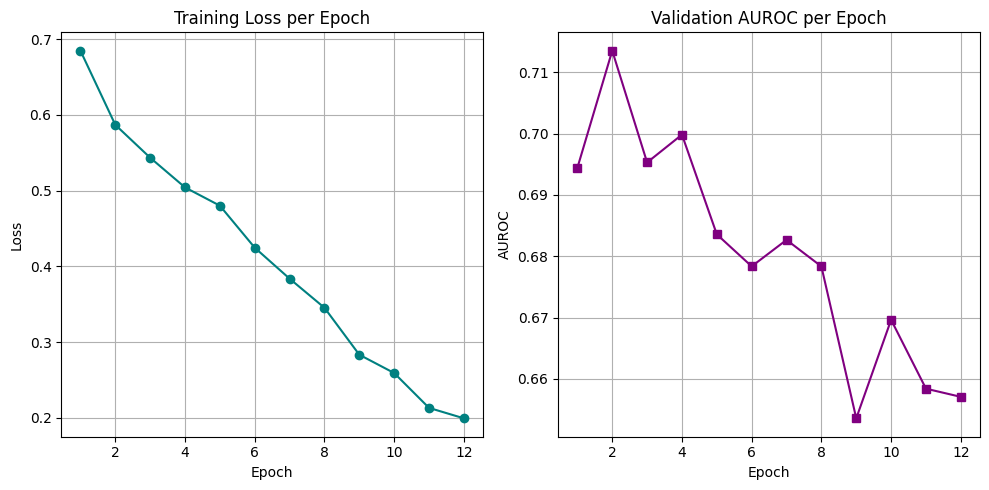

CPU times: user 5h 20min, sys: 31min 42s, total: 5h 51min 43s
Wall time: 7min 20s


In [ ]:
%%time

# Create a weighted random sampler to handle class imbalance
class_weights = [1.0 / Counter(y_train)[cls] for cls in y_train]
sampler = WeightedRandomSampler(class_weights, len(y_train))

# Train
trainer.train(X_train, y_train, None, X_val, y_val, sampler=sampler, patch_length=patch_len, stride=stride, epochs=epochs, batch_size=batch_size)

# Note: use below code if running in the local machine
# patchTST_save_path = r'../models/patchtst_model_v2.pt'

# Note: use below code if running in the Google colab
patchTST_save_path = os.path.join(basePath, 'models', 'patchtst_model_v2.pt')

# Save model weights and config
trainer.save_model(patchTST_save_path, config)

# Plot training metrics
trainer.plot_training_metrics()

### 6.2 Evaluation

This section evaluates the performance of the trained PatchTSTForClassification model on the test set. It first loads the saved model and then uses the `evaluate` method of the `PatchTST_Trainer` to get the predictions and targets for the test set. Finally, it prints the test AUROC, a classification report, and plots the confusion matrix, ROC curve, and precision-recall curve to provide a comprehensive evaluation of the model's performance.

**Interpretations:**

- A Test **AUROC of 0.6295** indicates that the model has a modest ability to distinguish between patients who will survive and those who will die. An AUROC of 0.5 represents a model with no discriminative ability (equivalent to random guessing), while an AUROC of 1.0 represents a model with perfect discriminative ability. Therefore, a score of 0.6295 suggests that the model is better than random guessing, but there is still significant room for improvement.

- **Classification report:**

  *   **Precision (Survived):** When the model predicts that a patient will survive, it is correct 92.25% of the time. This is a high-precision result, which is good.
  *   **Recall (Survived):** The model correctly identifies 50.15% of all patients who actually survived. This means that the model misses about half of the patients who survived.
  *   **Precision (Died):** When the model predicts that a patient will die, it is correct only 19.10% of the time. This is a very low precision, which is a major concern. It means that there are many false positives (the model predicts death, but the patient survives).
  *   **Recall (Died):** The model correctly identifies 73.64% of all patients who actually died. This is a good recall, which means that the model is good at identifying patients who are at high risk of dying.
  *   **Accuracy:** The overall accuracy of the model is 53.38%, which is not much better than random guessing.
  *   **F1-score:** The F1-score is a weighted average of precision and recall. The F1-score for the "survived" class is 0.6497, which is reasonable, but the F1-score for the "died" class is only 0.3034, which is very low.

  In summary, the model is good at identifying patients who will survive, but it is very bad at identifying patients who will die. The model has a high number of false positives, which means that it predicts that many patients will die, but they actually survive. This is a major issue, as it could lead to unnecessary and costly interventions.

- **Confusion matrix:**

  *   **True Positives (TP):** 81 - The model correctly predicted that 81 patients would die.
  *   **True Negatives (TN):** 345 - The model correctly predicted that 345 patients would survive.
  *   **False Positives (FP):** 343 - The model incorrectly predicted that 343 patients would die, but they actually survived. This is a Type I error.
  *   **False Negatives (FN):** 29 - The model incorrectly predicted that 29 patients would survive, but they actually died. This is a Type II error.

  The confusion matrix confirms what we saw in the classification report: the model is good at predicting survival but bad at predicting death. The high number of false positives is a major concern.

- **ROC Curve:**

  The ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different classification thresholds. An ideal ROC curve would hug the top-left corner, indicating a high TPR and a low FPR. The AUROC (Area Under the ROC Curve) is **0.6295**, which is a quantitative measure of the model's ability to distinguish between the two classes. As mentioned before, this value suggests that the model has a modest discriminative ability, but it is better than random guessing.

- **PR Curve:**

  The PR curve shows the trade-off between precision and recall at different classification thresholds. An ideal PR curve would hug the top-right corner, indicating high precision and high recall. The PR AUC (Area Under the PR Curve) is 0.1911, which is **very low**. This indicates that the model has poor performance in terms of both precision and recall, especially for the "died" class. The PR curve is particularly useful when dealing with imbalanced datasets, as it provides a more informative picture of the model's performance than the ROC curve.

Test AUROC: 0.6295


Classification Report @ Threshold = 0.0305:
              precision    recall  f1-score   support

           0     0.9225    0.5015    0.6497       688
           1     0.1910    0.7364    0.3034       110

    accuracy                         0.5338       798
   macro avg     0.5567    0.6189    0.4765       798
weighted avg     0.8216    0.5338    0.6020       798



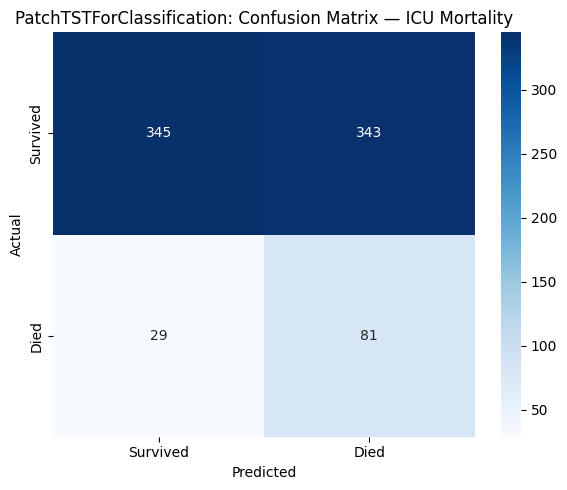

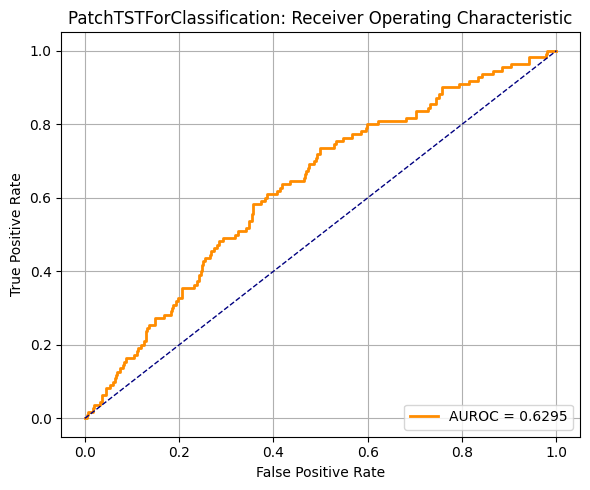

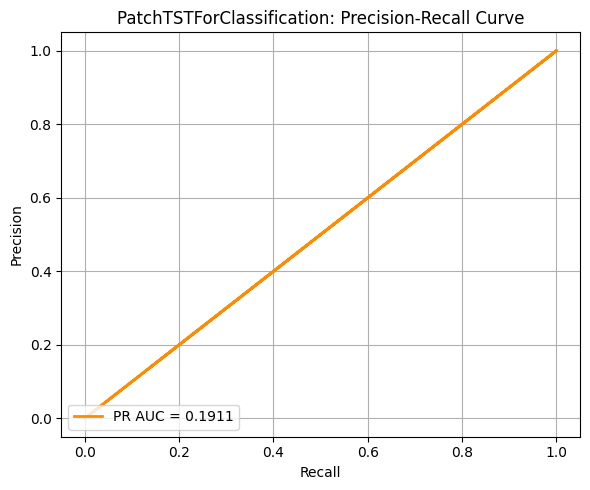

In [ ]:
# Load saved model (if running evaluation later, initialize trainer and load saved model)
# trainer = PatchTST_Trainer()
# trainer.load_model(patchTST_save_path)

# Evaluate on test set
test_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, attention_mask=None, patch_length=patch_len, stride=stride), batch_size=batch_size, shuffle=False)
test_preds, test_targets = trainer.evaluate(test_loader)

# Display AUROC metric
print(f"Test AUROC: {trainer.calculate_auroc(test_preds, test_targets):.4f}\n")

# Classification report
trainer.classification_report(test_preds, test_targets)

# Plot confusion matrix
trainer.plot_confusion_matrix(test_preds, test_targets)

# Plot ROC curve
trainer.plot_roc_curve(test_preds, test_targets)

# Plot PR curve
trainer.plot_pr_curve(test_preds, test_targets)

## 7. Custom Configuration Model

This section trains and evaluates a custom-configured PatchTSTForClassification model. It first defines a new configuration with more layers, attention heads, and dropout than the baseline model. It then trains the model using a lower learning rate and a different weight decay. Finally, it evaluates the model on the test set and provides a comprehensive evaluation of its performance.

### 7.1 Model Training

This section trains a custom-configured PatchTSTForClassification model. It defines a new configuration with more layers, attention heads, and dropout than the baseline model. It then initializes the `PatchTST_Trainer` with the new model, a lower learning rate, and a different weight decay. Finally, the model is trained using the `train` method of the trainer, and the trained model is saved to a file.

**Training Metrics Plot Inference:**

The training loss fluctuates around 0.695, while the validation AUROC consistently increases. This indicates that the model is learning and generalizing well to the validation data. The model does not appear to be overfitting, as the validation AUROC is not decreasing.

In [ ]:
# Create the config
config_ft = PatchTSTConfig(
    num_input_channels=num_input_channels,
    context_length=context_length,
    patch_len=patch_len,
    stride=stride,
    use_cls_token=True,
    num_targets=2,
    d_model=64,
    ffn_dim=128,
    num_hidden_layers=4,
    num_attention_heads=8,
    attention_dropout=0.2,
    ff_dropout=0.2,
    path_dropout=0.1,
    positional_dropout=0.1,
    head_dropout=0.1,
    norm_type="layernorm",
    loss="bce_with_logits",
    channel_consistent_masking=True,
    share_embedding=False,

)

# Create the model
ft_model = PatchTSTForClassification(config_ft)

# Set the learning rate and weight decay
learning_rate=1e-5
weight_decay=1e-4

# Initialize trainer
ft_trainer = PatchTST_Trainer(ft_model, learning_rate=learning_rate, weight_decay=weight_decay, early_stopping_patience=early_stopping_patience)

Epoch 01: Loss = 0.6968 | AUROC = 0.5307
Epoch 02: Loss = 0.6975 | AUROC = 0.5390
Epoch 03: Loss = 0.6984 | AUROC = 0.5481
Epoch 04: Loss = 0.6982 | AUROC = 0.5571
Epoch 05: Loss = 0.6953 | AUROC = 0.5644
Epoch 06: Loss = 0.6958 | AUROC = 0.5692
Epoch 07: Loss = 0.6940 | AUROC = 0.5729
Epoch 08: Loss = 0.6976 | AUROC = 0.5803
Epoch 09: Loss = 0.6933 | AUROC = 0.5834
Epoch 10: Loss = 0.6951 | AUROC = 0.5860
Epoch 11: Loss = 0.6958 | AUROC = 0.5902
Epoch 12: Loss = 0.6946 | AUROC = 0.5961
Epoch 13: Loss = 0.6957 | AUROC = 0.5991
Epoch 14: Loss = 0.6950 | AUROC = 0.6032
Epoch 15: Loss = 0.6962 | AUROC = 0.6076
Epoch 16: Loss = 0.6965 | AUROC = 0.6099
Epoch 17: Loss = 0.6968 | AUROC = 0.6115
Epoch 18: Loss = 0.6936 | AUROC = 0.6137
Epoch 19: Loss = 0.6949 | AUROC = 0.6160
Epoch 20: Loss = 0.6947 | AUROC = 0.6193
Epoch 21: Loss = 0.6937 | AUROC = 0.6229
Epoch 22: Loss = 0.6969 | AUROC = 0.6229
Epoch 23: Loss = 0.6932 | AUROC = 0.6252
Epoch 24: Loss = 0.6947 | AUROC = 0.6279
Epoch 25: Loss =

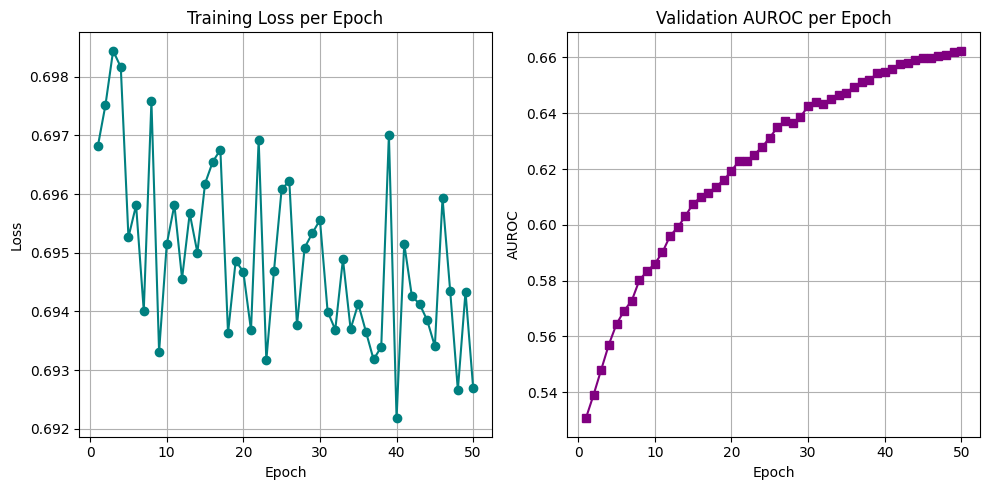

CPU times: user 12h 42min 9s, sys: 2min 48s, total: 12h 44min 58s
Wall time: 19min 25s


In [ ]:
%%time

# Train
ft_trainer.train(X_train, y_train, None, X_val, y_val, sampler=sampler, patch_length=patch_len, stride=stride, epochs=epochs, batch_size=batch_size)

# Note: use below code if running in the local machine
# patchTST_ft_save_path = r'../models/patchtst_model_ft_v2.pt'

# Note: use below code if running in the Google colab
patchTST_ft_save_path = os.path.join(basePath, 'models', 'patchtst_model_ft_v2.pt')

# Save model weights and config
ft_trainer.save_model(patchTST_ft_save_path, config_ft)

# Plot training metrics
ft_trainer.plot_training_metrics()

### 7.2 Evaluation

This section evaluates the performance of the custom-configured PatchTSTForClassification model on the test set. It first loads the saved model and then uses the `evaluate` method of the `PatchTST_Trainer` to get the predictions and targets for the test set. Finally, it prints the test AUROC, a classification report, and plots the confusion matrix, ROC curve, and precision-recall curve to provide a comprehensive evaluation of the model's performance.

**Interpretations:**

- A Test **AUROC of 0.6997** indicates that the model has a better ability to distinguish between patients who will survive and those who will die compared to the baseline model (AUROC 0.6295). This score suggests that the custom configuration has improved the model's discriminative power, but there is still room for improvement.

- **Classification report:**

  *   **Precision (Survived):** When the model predicts that a patient will survive, it is correct 92.69% of the time. This is a high-precision result, which is good.
  *   **Recall (Survived):** The model correctly identifies 75.58% of all patients who actually survived.
  *   **Precision (Died):** When the model predicts that a patient will die, it is correct only 29.11% of the time. This is a low precision, but it is an improvement over the baseline model.
  *   **Recall (Died):** The model correctly identifies 62.73% of all patients who actually died.
  *   **Accuracy:** The overall accuracy of the model is 73.81%, which is a significant improvement over the baseline model.
  *   **F1-score:** The F1-score for the "survived" class is 0.8327, which is good, and the F1-score for the "died" class is 0.3977, which is an improvement over the baseline model, but still low.

  In summary, the custom-configured model is a significant improvement over the baseline model. It is better at identifying patients who will survive and who will die. However, the precision for the "died" class is still low, which means that the model still has a high number of false positives.

- **Confusion matrix:**

  *   **True Positives (TP):** 69 - The model correctly predicted that 69 patients would die.
  *   **True Negatives (TN):** 520 - The model correctly predicted that 520 patients would survive.
  *   **False Positives (FP):** 168 - The model incorrectly predicted that 168 patients would die, but they actually survived. This is a Type I error.
  *   **False Negatives (FN):** 41 - The model incorrectly predicted that 41 patients would survive, but they actually died. This is a Type II error.

  The confusion matrix confirms what we saw in the classification report: the model is better at predicting survival than death, but the number of false positives has decreased compared to the baseline model.

- **ROC Curve:**

  The ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different classification thresholds. The AUROC of 0.6997 indicates a better-than-random-chance ability of the model to distinguish between the two classes.

- **PR Curve:**

  The PR curve shows the trade-off between precision and recall. The PR AUC of 0.2678 is still low, indicating that the model struggles to achieve high precision and high recall simultaneously. This is common in imbalanced datasets.

Test AUROC: 0.6997


Classification Report @ Threshold = 0.4928:
              precision    recall  f1-score   support

           0     0.9269    0.7558    0.8327       688
           1     0.2911    0.6273    0.3977       110

    accuracy                         0.7381       798
   macro avg     0.6090    0.6915    0.6152       798
weighted avg     0.8393    0.7381    0.7727       798



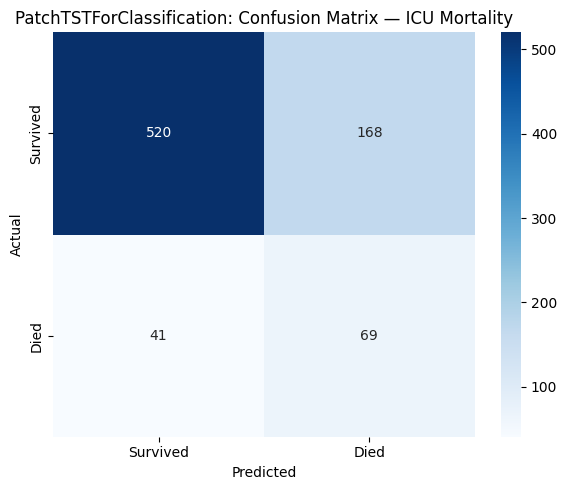

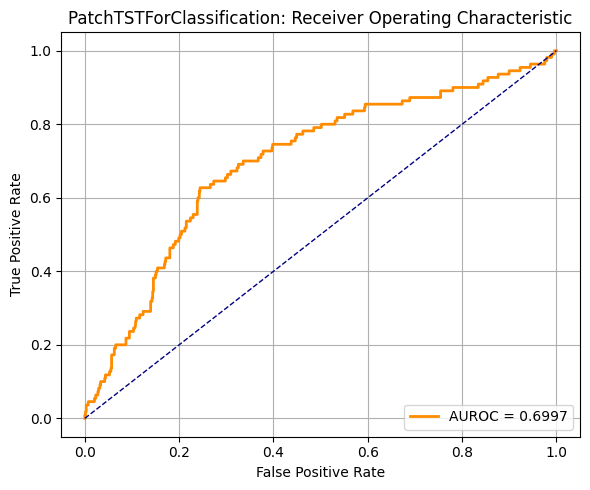

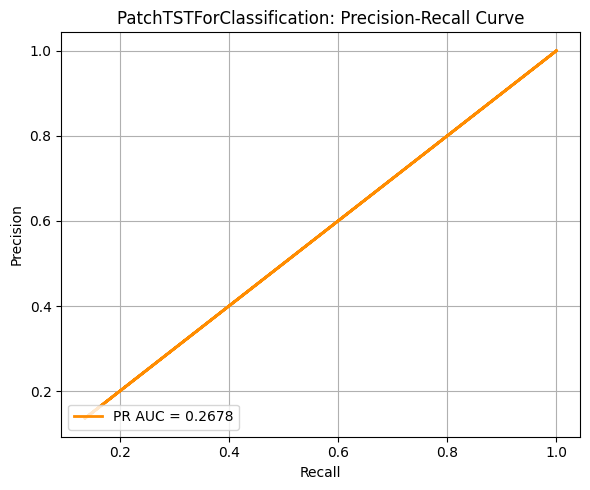

In [ ]:
# Load saved model (if running evaluation later, initialize trainer and load saved model)
# ft_trainer = PatchTST_Trainer()
# ft_trainer.load_model(patchTST_ft_save_path)

# Evaluate on test set
ft_test_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, attention_mask=None, patch_length=patch_len, stride=stride), batch_size=batch_size, shuffle=False)
ft_test_preds, ft_test_targets = ft_trainer.evaluate(ft_test_loader)

# Display AUROC metric
print(f"Test AUROC: {ft_trainer.calculate_auroc(ft_test_preds, ft_test_targets):.4f}\n")

# Classification report
ft_trainer.classification_report(ft_test_preds, ft_test_targets)

# Plot confusion matrix
ft_trainer.plot_confusion_matrix(ft_test_preds, ft_test_targets)

# Plot ROC curve
ft_trainer.plot_roc_curve(ft_test_preds, ft_test_targets)

# Plot PR curve
ft_trainer.plot_pr_curve(ft_test_preds, ft_test_targets)

## 8. Hyperparameter Tuning with Optuna

This section uses Optuna to perform hyperparameter tuning for the PatchTSTForClassification model, evaluates the performance of the best model found by Optuna and uses the SHAP library for model interpretation.

### 8.1 Model Training

This section uses Optuna to perform hyperparameter tuning for the PatchTSTForClassification model. It defines an `objective` function that takes a trial object as input and returns the validation AUROC. The `objective` function defines the search space for the hyperparameters, creates a `PatchTSTConfig` object, initializes a `PatchTST_Trainer`, trains the model, and returns the best validation AUROC. The `study.optimize` function is then called to run the hyperparameter tuning for a specified number of trials. The best hyperparameters are then printed.

In [ ]:
def objective(trial, save_path):
    # hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128])
    num_layers = trial.suggest_int("num_hidden_layers", 3, 6)
    num_heads = trial.suggest_categorical("num_attention_heads", [2, 4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    patch_len = trial.suggest_categorical("patch_len", [8, 12, 16])
    stride = trial.suggest_categorical("stride", [4, 6, 8])
    norm_type = trial.suggest_categorical("norm_type", ["layernorm", "batchnorm"])
    learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay=trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    epochs = trial.suggest_int("epochs", 100, 150)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Dynamically calculate the new input shape
    num_input_channels = 21 * patch_len
    context_length = (48 - patch_len) // stride + 1
    ffn_dim = hidden_size * 2

    # Create the config
    config = PatchTSTConfig(
        num_input_channels=num_input_channels,
        context_length=context_length,
        patch_len=patch_len,
        stride=stride,
        use_cls_token=True,
        num_targets=2,
        d_model=hidden_size,
        ffn_dim=ffn_dim,
        num_hidden_layers=num_layers,
        num_attention_heads=num_heads,
        attention_dropout=dropout,
        ff_dropout=dropout,
        positional_dropout=0.1,
        path_dropout=dropout,
        head_dropout=0.1,
        norm_type=norm_type,
        loss="bce_with_logits",
        channel_consistent_masking=True,
        share_embedding=False
    )

    # Create the model
    model = PatchTSTForClassification(config)

    # Initialize trainer
    trainer = PatchTST_Trainer(model, learning_rate=learning_rate, weight_decay=weight_decay, early_stopping_patience=early_stopping_patience)

    # Train
    trainer.train(X_train, y_train, None, X_val, y_val, sampler=sampler, patch_length=patch_len, stride=stride, epochs=epochs, batch_size=batch_size)

    # Get the best AUROC score from the training process
    auroc = trainer.best_score

    # Save the model if it's the best one so far
    if auroc is not None and (trial.number == 0 or auroc > study.best_value):
        trial.set_user_attr("patch_len", patch_len)
        trial.set_user_attr("stride", stride)
        trial.set_user_attr("batch_size", batch_size)
        trainer.save_model(save_path, config, best_trial=trial)

    print(f"Trial {trial.number}: AUROC = {auroc:.4f}")

    return auroc if auroc is not None else 0.0

In [ ]:
%%time

# Note: use below code if running in the local machine
# patchTST_bm_save_path = r'../models/patchtst_model_bm_v2.pt'

# Note: use below code if running in the Google colab
patchTST_bm_save_path = os.path.join(basePath, 'models', 'patchtst_model_bm_v2.pt')

# Create a new study
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, patchTST_bm_save_path), n_trials=25)

# Display best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-08-02 00:54:42,139] A new study created in memory with name: no-name-f18e9711-8655-4880-933e-afbebecb4c6c


Epoch 01: Loss = 0.7094 | AUROC = 0.4809
Epoch 02: Loss = 0.7038 | AUROC = 0.5225
Epoch 03: Loss = 0.6945 | AUROC = 0.5750
Epoch 04: Loss = 0.6984 | AUROC = 0.5729
Epoch 05: Loss = 0.7080 | AUROC = 0.6132
Epoch 06: Loss = 0.7036 | AUROC = 0.6040
Epoch 07: Loss = 0.7019 | AUROC = 0.6172
Epoch 08: Loss = 0.7013 | AUROC = 0.6184
Epoch 09: Loss = 0.7003 | AUROC = 0.6210
Epoch 10: Loss = 0.7001 | AUROC = 0.6344
Epoch 11: Loss = 0.6974 | AUROC = 0.6309
Epoch 12: Loss = 0.6853 | AUROC = 0.6343
Epoch 13: Loss = 0.6834 | AUROC = 0.6501
Epoch 14: Loss = 0.6571 | AUROC = 0.6661
Epoch 15: Loss = 0.6560 | AUROC = 0.6818
Epoch 16: Loss = 0.6300 | AUROC = 0.6917
Epoch 17: Loss = 0.6240 | AUROC = 0.7042
Epoch 18: Loss = 0.6283 | AUROC = 0.7043
Epoch 19: Loss = 0.6021 | AUROC = 0.7046
Epoch 20: Loss = 0.5951 | AUROC = 0.7043
Epoch 21: Loss = 0.5940 | AUROC = 0.7007
Epoch 22: Loss = 0.5948 | AUROC = 0.6971
Epoch 23: Loss = 0.5743 | AUROC = 0.6963
Epoch 24: Loss = 0.5847 | AUROC = 0.6844
Epoch 25: Loss =

[I 2025-08-02 01:01:54,723] Trial 0 finished with value: 0.7045855725101008 and parameters: {'hidden_size': 64, 'num_hidden_layers': 4, 'num_attention_heads': 8, 'dropout': 0.3314783081936318, 'patch_len': 8, 'stride': 6, 'norm_type': 'layernorm', 'learning_rate': 0.00021753216925612115, 'weight_decay': 1.4889810755405865e-05, 'epochs': 113, 'batch_size': 64}. Best is trial 0 with value: 0.7045855725101008.


Epoch 29: Loss = 0.5234 | AUROC = 0.6721
Early stopping triggered
Trial 0: AUROC = 0.7046
Epoch 01: Loss = 0.7005 | AUROC = 0.5146
Epoch 02: Loss = 0.6971 | AUROC = 0.5422
Epoch 03: Loss = 0.6938 | AUROC = 0.5563
Epoch 04: Loss = 0.6970 | AUROC = 0.5788
Epoch 05: Loss = 0.6962 | AUROC = 0.6001
Epoch 06: Loss = 0.6961 | AUROC = 0.6127
Epoch 07: Loss = 0.6930 | AUROC = 0.6173
Epoch 08: Loss = 0.6982 | AUROC = 0.6211
Epoch 09: Loss = 0.6969 | AUROC = 0.6318
Epoch 10: Loss = 0.6991 | AUROC = 0.6382
Epoch 11: Loss = 0.6956 | AUROC = 0.6437
Epoch 12: Loss = 0.6962 | AUROC = 0.6479
Epoch 13: Loss = 0.6953 | AUROC = 0.6485
Epoch 14: Loss = 0.6967 | AUROC = 0.6525
Epoch 15: Loss = 0.6949 | AUROC = 0.6514
Epoch 16: Loss = 0.6944 | AUROC = 0.6526
Epoch 17: Loss = 0.6968 | AUROC = 0.6555
Epoch 18: Loss = 0.6972 | AUROC = 0.6596
Epoch 19: Loss = 0.6948 | AUROC = 0.6613
Epoch 20: Loss = 0.6983 | AUROC = 0.6644
Epoch 21: Loss = 0.6939 | AUROC = 0.6692
Epoch 22: Loss = 0.6950 | AUROC = 0.6704
Epoch 23

[I 2025-08-02 01:44:37,888] Trial 1 finished with value: 0.7239765164293467 and parameters: {'hidden_size': 64, 'num_hidden_layers': 3, 'num_attention_heads': 4, 'dropout': 0.3047873156630499, 'patch_len': 8, 'stride': 4, 'norm_type': 'layernorm', 'learning_rate': 7.922694625052197e-05, 'weight_decay': 8.878307205912305e-05, 'epochs': 133, 'batch_size': 128}. Best is trial 1 with value: 0.7239765164293467.


Epoch 61: Loss = 0.5814 | AUROC = 0.7066
Early stopping triggered
Trial 1: AUROC = 0.7240
Epoch 01: Loss = 0.7033 | AUROC = 0.5621
Epoch 02: Loss = 0.7049 | AUROC = 0.5812
Epoch 03: Loss = 0.7082 | AUROC = 0.5779
Epoch 04: Loss = 0.7062 | AUROC = 0.5897
Epoch 05: Loss = 0.7048 | AUROC = 0.5997
Epoch 06: Loss = 0.7029 | AUROC = 0.6097
Epoch 07: Loss = 0.6993 | AUROC = 0.6150
Epoch 08: Loss = 0.7028 | AUROC = 0.6195
Epoch 09: Loss = 0.6996 | AUROC = 0.6203
Epoch 10: Loss = 0.6998 | AUROC = 0.6180
Epoch 11: Loss = 0.7021 | AUROC = 0.6179
Epoch 12: Loss = 0.7033 | AUROC = 0.6182
Epoch 13: Loss = 0.6998 | AUROC = 0.6191
Epoch 14: Loss = 0.6998 | AUROC = 0.6179
Epoch 15: Loss = 0.6970 | AUROC = 0.6195
Epoch 16: Loss = 0.6991 | AUROC = 0.6203
Epoch 17: Loss = 0.6972 | AUROC = 0.6222
Epoch 18: Loss = 0.7018 | AUROC = 0.6218
Epoch 19: Loss = 0.6944 | AUROC = 0.6229
Epoch 20: Loss = 0.6944 | AUROC = 0.6228
Epoch 21: Loss = 0.6922 | AUROC = 0.6227
Epoch 22: Loss = 0.6953 | AUROC = 0.6241
Epoch 23

[I 2025-08-02 03:42:01,514] Trial 2 finished with value: 0.7275722747420862 and parameters: {'hidden_size': 64, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'dropout': 0.33064535670212847, 'patch_len': 12, 'stride': 8, 'norm_type': 'batchnorm', 'learning_rate': 0.00011295491925221065, 'weight_decay': 2.1355228463240986e-05, 'epochs': 131, 'batch_size': 128}. Best is trial 2 with value: 0.7275722747420862.


Epoch 62: Loss = 0.5333 | AUROC = 0.7150
Early stopping triggered
Trial 2: AUROC = 0.7276
Epoch 01: Loss = 0.8216 | AUROC = 0.6345
Epoch 02: Loss = 0.7444 | AUROC = 0.6243
Epoch 03: Loss = 0.7507 | AUROC = 0.6645
Epoch 04: Loss = 0.6935 | AUROC = 0.7030
Epoch 05: Loss = 0.6564 | AUROC = 0.7074
Epoch 06: Loss = 0.6530 | AUROC = 0.7120
Epoch 07: Loss = 0.6344 | AUROC = 0.7201
Epoch 08: Loss = 0.6151 | AUROC = 0.7194
Epoch 09: Loss = 0.5979 | AUROC = 0.7255
Epoch 10: Loss = 0.5963 | AUROC = 0.7282
Epoch 11: Loss = 0.5843 | AUROC = 0.7278
Epoch 12: Loss = 0.5677 | AUROC = 0.7186
Epoch 13: Loss = 0.5619 | AUROC = 0.7305
Epoch 14: Loss = 0.5667 | AUROC = 0.7333
Epoch 15: Loss = 0.5615 | AUROC = 0.7177
Epoch 16: Loss = 0.5473 | AUROC = 0.7278
Epoch 17: Loss = 0.5201 | AUROC = 0.7132
Epoch 18: Loss = 0.5463 | AUROC = 0.7121
Epoch 19: Loss = 0.5310 | AUROC = 0.7253
Epoch 20: Loss = 0.4987 | AUROC = 0.7199
Epoch 21: Loss = 0.5423 | AUROC = 0.6922
Epoch 22: Loss = 0.4864 | AUROC = 0.7121
Epoch 23

[I 2025-08-02 04:52:26,823] Trial 3 finished with value: 0.7332601106186012 and parameters: {'hidden_size': 128, 'num_hidden_layers': 5, 'num_attention_heads': 8, 'dropout': 0.1817705715373022, 'patch_len': 12, 'stride': 8, 'norm_type': 'batchnorm', 'learning_rate': 0.00033126789460392317, 'weight_decay': 0.0006583642866610827, 'epochs': 104, 'batch_size': 64}. Best is trial 3 with value: 0.7332601106186012.


Epoch 24: Loss = 0.4755 | AUROC = 0.7082
Early stopping triggered
Trial 3: AUROC = 0.7333
Epoch 01: Loss = 0.7508 | AUROC = 0.6664
Epoch 02: Loss = 0.7171 | AUROC = 0.6485
Epoch 03: Loss = 0.7092 | AUROC = 0.6534
Epoch 04: Loss = 0.6976 | AUROC = 0.6790
Epoch 05: Loss = 0.6770 | AUROC = 0.6941
Epoch 06: Loss = 0.6553 | AUROC = 0.7103
Epoch 07: Loss = 0.6276 | AUROC = 0.7166
Epoch 08: Loss = 0.6267 | AUROC = 0.7170
Epoch 09: Loss = 0.5839 | AUROC = 0.7097
Epoch 10: Loss = 0.5804 | AUROC = 0.7077
Epoch 11: Loss = 0.5960 | AUROC = 0.7233
Epoch 12: Loss = 0.5859 | AUROC = 0.7286
Epoch 13: Loss = 0.5669 | AUROC = 0.7156
Epoch 14: Loss = 0.5461 | AUROC = 0.7230
Epoch 15: Loss = 0.5466 | AUROC = 0.7241
Epoch 16: Loss = 0.5384 | AUROC = 0.7206
Epoch 17: Loss = 0.5379 | AUROC = 0.7212
Epoch 18: Loss = 0.5551 | AUROC = 0.7200
Epoch 19: Loss = 0.5242 | AUROC = 0.7237
Epoch 20: Loss = 0.5308 | AUROC = 0.7268
Epoch 21: Loss = 0.5419 | AUROC = 0.7318
Epoch 22: Loss = 0.5219 | AUROC = 0.7225
Epoch 23

[I 2025-08-02 05:59:30,043] Trial 4 finished with value: 0.7318479582630526 and parameters: {'hidden_size': 128, 'num_hidden_layers': 3, 'num_attention_heads': 2, 'dropout': 0.12298588577977841, 'patch_len': 12, 'stride': 8, 'norm_type': 'batchnorm', 'learning_rate': 0.00013075190578556146, 'weight_decay': 0.0005031655157195445, 'epochs': 140, 'batch_size': 64}. Best is trial 3 with value: 0.7332601106186012.


Epoch 31: Loss = 0.4673 | AUROC = 0.7236
Early stopping triggered
Trial 4: AUROC = 0.7318
Epoch 01: Loss = 0.9096 | AUROC = 0.5367
Epoch 02: Loss = 0.9275 | AUROC = 0.6047
Epoch 03: Loss = 0.8937 | AUROC = 0.6281
Epoch 04: Loss = 0.8996 | AUROC = 0.6379
Epoch 05: Loss = 0.9233 | AUROC = 0.6497
Epoch 06: Loss = 0.8754 | AUROC = 0.6644
Epoch 07: Loss = 0.8292 | AUROC = 0.6742
Epoch 08: Loss = 0.8329 | AUROC = 0.6970
Epoch 09: Loss = 0.8334 | AUROC = 0.7088
Epoch 10: Loss = 0.8090 | AUROC = 0.7055
Epoch 11: Loss = 0.7948 | AUROC = 0.7102
Epoch 12: Loss = 0.7732 | AUROC = 0.6746
Epoch 13: Loss = 0.7643 | AUROC = 0.6555
Epoch 14: Loss = 0.7526 | AUROC = 0.6801
Epoch 15: Loss = 0.7611 | AUROC = 0.6890
Epoch 16: Loss = 0.7315 | AUROC = 0.6875
Epoch 17: Loss = 0.7746 | AUROC = 0.6967
Epoch 18: Loss = 0.7131 | AUROC = 0.6846
Epoch 19: Loss = 0.8183 | AUROC = 0.6691
Epoch 20: Loss = 0.7185 | AUROC = 0.6854


[I 2025-08-02 06:18:51,541] Trial 5 finished with value: 0.710234181932295 and parameters: {'hidden_size': 128, 'num_hidden_layers': 5, 'num_attention_heads': 8, 'dropout': 0.4908283912732311, 'patch_len': 12, 'stride': 6, 'norm_type': 'layernorm', 'learning_rate': 0.00044347732807032943, 'weight_decay': 0.00021125617899993388, 'epochs': 115, 'batch_size': 32}. Best is trial 3 with value: 0.7332601106186012.


Epoch 21: Loss = 0.6906 | AUROC = 0.6854
Early stopping triggered
Trial 5: AUROC = 0.7102
Epoch 01: Loss = 0.8841 | AUROC = 0.6786
Epoch 02: Loss = 0.6739 | AUROC = 0.7095
Epoch 03: Loss = 0.6580 | AUROC = 0.6849
Epoch 04: Loss = 0.6176 | AUROC = 0.7175
Epoch 05: Loss = 0.5970 | AUROC = 0.7284
Epoch 06: Loss = 0.6006 | AUROC = 0.7276
Epoch 07: Loss = 0.5548 | AUROC = 0.7122
Epoch 08: Loss = 0.5895 | AUROC = 0.7367
Epoch 09: Loss = 0.5369 | AUROC = 0.7259
Epoch 10: Loss = 0.5365 | AUROC = 0.7306
Epoch 11: Loss = 0.5214 | AUROC = 0.7005
Epoch 12: Loss = 0.5128 | AUROC = 0.6949
Epoch 13: Loss = 0.5042 | AUROC = 0.6996
Epoch 14: Loss = 0.4990 | AUROC = 0.7337
Epoch 15: Loss = 0.4891 | AUROC = 0.7094
Epoch 16: Loss = 0.5022 | AUROC = 0.7219
Epoch 17: Loss = 0.4745 | AUROC = 0.6916


[I 2025-08-02 07:58:34,835] Trial 6 finished with value: 0.7366858876292839 and parameters: {'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'dropout': 0.1024826576455149, 'patch_len': 16, 'stride': 4, 'norm_type': 'batchnorm', 'learning_rate': 0.0005530342574439091, 'weight_decay': 0.0002376567041103368, 'epochs': 143, 'batch_size': 32}. Best is trial 6 with value: 0.7366858876292839.


Epoch 18: Loss = 0.4796 | AUROC = 0.6941
Early stopping triggered
Trial 6: AUROC = 0.7367
Epoch 01: Loss = 1.0708 | AUROC = 0.6734
Epoch 02: Loss = 0.7816 | AUROC = 0.6855
Epoch 03: Loss = 0.7855 | AUROC = 0.6977
Epoch 04: Loss = 0.6543 | AUROC = 0.7076
Epoch 05: Loss = 0.7406 | AUROC = 0.7018
Epoch 06: Loss = 0.7077 | AUROC = 0.7041
Epoch 07: Loss = 0.6673 | AUROC = 0.6890
Epoch 08: Loss = 0.6136 | AUROC = 0.6827
Epoch 09: Loss = 0.6353 | AUROC = 0.6900
Epoch 10: Loss = 0.6321 | AUROC = 0.7022
Epoch 11: Loss = 0.6346 | AUROC = 0.6758
Epoch 12: Loss = 0.5822 | AUROC = 0.7263
Epoch 13: Loss = 0.5862 | AUROC = 0.6735
Epoch 14: Loss = 0.5487 | AUROC = 0.6775
Epoch 15: Loss = 0.5615 | AUROC = 0.7029
Epoch 16: Loss = 0.5787 | AUROC = 0.6834
Epoch 17: Loss = 0.5329 | AUROC = 0.6621
Epoch 18: Loss = 0.5265 | AUROC = 0.6814
Epoch 19: Loss = 0.5000 | AUROC = 0.6963
Epoch 20: Loss = 0.5697 | AUROC = 0.6471
Epoch 21: Loss = 0.5297 | AUROC = 0.6524


[I 2025-08-02 09:37:13,211] Trial 7 finished with value: 0.7263301036885944 and parameters: {'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 2, 'dropout': 0.1362212536809031, 'patch_len': 12, 'stride': 4, 'norm_type': 'layernorm', 'learning_rate': 0.0008087070044244581, 'weight_decay': 0.00029914540192372, 'epochs': 109, 'batch_size': 32}. Best is trial 6 with value: 0.7366858876292839.


Epoch 22: Loss = 0.5462 | AUROC = 0.6962
Early stopping triggered
Trial 7: AUROC = 0.7263
Epoch 01: Loss = 0.7524 | AUROC = 0.6426
Epoch 02: Loss = 0.7074 | AUROC = 0.6617
Epoch 03: Loss = 0.6990 | AUROC = 0.6916
Epoch 04: Loss = 0.6662 | AUROC = 0.7034
Epoch 05: Loss = 0.6249 | AUROC = 0.7177
Epoch 06: Loss = 0.6225 | AUROC = 0.7227
Epoch 07: Loss = 0.6046 | AUROC = 0.7288
Epoch 08: Loss = 0.5938 | AUROC = 0.7233
Epoch 09: Loss = 0.5959 | AUROC = 0.7174
Epoch 10: Loss = 0.5994 | AUROC = 0.7187
Epoch 11: Loss = 0.5759 | AUROC = 0.7326
Epoch 12: Loss = 0.5654 | AUROC = 0.7172
Epoch 13: Loss = 0.5563 | AUROC = 0.7121
Epoch 14: Loss = 0.5600 | AUROC = 0.7106
Epoch 15: Loss = 0.5416 | AUROC = 0.7188
Epoch 16: Loss = 0.5856 | AUROC = 0.7003
Epoch 17: Loss = 0.5364 | AUROC = 0.7162
Epoch 18: Loss = 0.5327 | AUROC = 0.7135
Epoch 19: Loss = 0.5442 | AUROC = 0.7048
Epoch 20: Loss = 0.5263 | AUROC = 0.6960


[I 2025-08-02 09:46:28,656] Trial 8 finished with value: 0.7325932608951476 and parameters: {'hidden_size': 64, 'num_hidden_layers': 3, 'num_attention_heads': 2, 'dropout': 0.3430944593068862, 'patch_len': 16, 'stride': 8, 'norm_type': 'batchnorm', 'learning_rate': 0.0006936798628885993, 'weight_decay': 8.297620100664679e-05, 'epochs': 101, 'batch_size': 64}. Best is trial 6 with value: 0.7366858876292839.


Epoch 21: Loss = 0.5266 | AUROC = 0.6935
Early stopping triggered
Trial 8: AUROC = 0.7326
Epoch 01: Loss = 0.7424 | AUROC = 0.6021
Epoch 02: Loss = 0.7483 | AUROC = 0.6096
Epoch 03: Loss = 0.7488 | AUROC = 0.6116
Epoch 04: Loss = 0.7382 | AUROC = 0.6152
Epoch 05: Loss = 0.7522 | AUROC = 0.6230
Epoch 06: Loss = 0.7380 | AUROC = 0.6255
Epoch 07: Loss = 0.7391 | AUROC = 0.6261
Epoch 08: Loss = 0.7363 | AUROC = 0.6239
Epoch 09: Loss = 0.7114 | AUROC = 0.6256
Epoch 10: Loss = 0.7397 | AUROC = 0.6245
Epoch 11: Loss = 0.7174 | AUROC = 0.6251
Epoch 12: Loss = 0.7244 | AUROC = 0.6269
Epoch 13: Loss = 0.7133 | AUROC = 0.6269
Epoch 14: Loss = 0.7149 | AUROC = 0.6269
Epoch 15: Loss = 0.7086 | AUROC = 0.6270
Epoch 16: Loss = 0.7135 | AUROC = 0.6290
Epoch 17: Loss = 0.7059 | AUROC = 0.6309
Epoch 18: Loss = 0.7157 | AUROC = 0.6337
Epoch 19: Loss = 0.7064 | AUROC = 0.6340
Epoch 20: Loss = 0.7057 | AUROC = 0.6367
Epoch 21: Loss = 0.7019 | AUROC = 0.6390
Epoch 22: Loss = 0.7044 | AUROC = 0.6436
Epoch 23

[I 2025-08-02 11:14:13,911] Trial 9 finished with value: 0.7248264229396304 and parameters: {'hidden_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4, 'dropout': 0.27509110249180113, 'patch_len': 12, 'stride': 6, 'norm_type': 'batchnorm', 'learning_rate': 2.731556457873173e-05, 'weight_decay': 1.4111567950424132e-05, 'epochs': 142, 'batch_size': 32}. Best is trial 6 with value: 0.7366858876292839.


Epoch 68: Loss = 0.5674 | AUROC = 0.7145
Early stopping triggered
Trial 9: AUROC = 0.7248
Epoch 01: Loss = 0.7329 | AUROC = 0.5135
Epoch 02: Loss = 0.7323 | AUROC = 0.5504
Epoch 03: Loss = 0.7357 | AUROC = 0.5779
Epoch 04: Loss = 0.7294 | AUROC = 0.5957
Epoch 05: Loss = 0.7214 | AUROC = 0.6007
Epoch 06: Loss = 0.7283 | AUROC = 0.6067
Epoch 07: Loss = 0.7275 | AUROC = 0.6121
Epoch 08: Loss = 0.7181 | AUROC = 0.6176
Epoch 09: Loss = 0.7143 | AUROC = 0.6196
Epoch 10: Loss = 0.7181 | AUROC = 0.6208
Epoch 11: Loss = 0.7125 | AUROC = 0.6229
Epoch 12: Loss = 0.7147 | AUROC = 0.6225
Epoch 13: Loss = 0.7174 | AUROC = 0.6232
Epoch 14: Loss = 0.7158 | AUROC = 0.6235
Epoch 15: Loss = 0.7083 | AUROC = 0.6252
Epoch 16: Loss = 0.7076 | AUROC = 0.6274
Epoch 17: Loss = 0.7175 | AUROC = 0.6282
Epoch 18: Loss = 0.7033 | AUROC = 0.6288
Epoch 19: Loss = 0.7057 | AUROC = 0.6320
Epoch 20: Loss = 0.7067 | AUROC = 0.6350
Epoch 21: Loss = 0.7012 | AUROC = 0.6359
Epoch 22: Loss = 0.7021 | AUROC = 0.6374
Epoch 23

[I 2025-08-02 16:34:27,361] Trial 10 finished with value: 0.7254801971783105 and parameters: {'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 2, 'dropout': 0.2191287654871783, 'patch_len': 16, 'stride': 4, 'norm_type': 'batchnorm', 'learning_rate': 1.4483893254939844e-05, 'weight_decay': 4.2624943881096516e-05, 'epochs': 150, 'batch_size': 32}. Best is trial 6 with value: 0.7366858876292839.


Epoch 57: Loss = 0.5925 | AUROC = 0.7236
Early stopping triggered
Trial 10: AUROC = 0.7255
Epoch 01: Loss = 0.8427 | AUROC = 0.6143
Epoch 02: Loss = 0.7340 | AUROC = 0.6369
Epoch 03: Loss = 0.7125 | AUROC = 0.6562
Epoch 04: Loss = 0.6919 | AUROC = 0.6930
Epoch 05: Loss = 0.6640 | AUROC = 0.7152
Epoch 06: Loss = 0.6250 | AUROC = 0.7294
Epoch 07: Loss = 0.6163 | AUROC = 0.7300
Epoch 08: Loss = 0.5921 | AUROC = 0.7367
Epoch 09: Loss = 0.5961 | AUROC = 0.7307
Epoch 10: Loss = 0.5784 | AUROC = 0.7310
Epoch 11: Loss = 0.5567 | AUROC = 0.7095
Epoch 12: Loss = 0.5822 | AUROC = 0.7090
Epoch 13: Loss = 0.5567 | AUROC = 0.7115
Epoch 14: Loss = 0.5482 | AUROC = 0.7212
Epoch 15: Loss = 0.5135 | AUROC = 0.7174
Epoch 16: Loss = 0.5275 | AUROC = 0.6886
Epoch 17: Loss = 0.5214 | AUROC = 0.6993


[I 2025-08-02 18:18:46,194] Trial 11 finished with value: 0.7367381895683782 and parameters: {'hidden_size': 128, 'num_hidden_layers': 5, 'num_attention_heads': 8, 'dropout': 0.1893140720787289, 'patch_len': 16, 'stride': 4, 'norm_type': 'batchnorm', 'learning_rate': 0.00028279332714999605, 'weight_decay': 0.0008386298644220104, 'epochs': 122, 'batch_size': 64}. Best is trial 11 with value: 0.7367381895683782.


Epoch 18: Loss = 0.5275 | AUROC = 0.6945
Early stopping triggered
Trial 11: AUROC = 0.7367
Epoch 01: Loss = 0.7762 | AUROC = 0.6396
Epoch 02: Loss = 0.7226 | AUROC = 0.6518
Epoch 03: Loss = 0.7225 | AUROC = 0.6663
Epoch 04: Loss = 0.6955 | AUROC = 0.6902
Epoch 05: Loss = 0.6673 | AUROC = 0.7250
Epoch 06: Loss = 0.6227 | AUROC = 0.7341
Epoch 07: Loss = 0.6005 | AUROC = 0.7365
Epoch 08: Loss = 0.6190 | AUROC = 0.7242
Epoch 09: Loss = 0.5977 | AUROC = 0.7370
Epoch 10: Loss = 0.5753 | AUROC = 0.7380
Epoch 11: Loss = 0.5851 | AUROC = 0.7277
Epoch 12: Loss = 0.5564 | AUROC = 0.7249
Epoch 13: Loss = 0.5741 | AUROC = 0.7203
Epoch 14: Loss = 0.5570 | AUROC = 0.7181
Epoch 15: Loss = 0.5487 | AUROC = 0.7036
Epoch 16: Loss = 0.5295 | AUROC = 0.7045
Epoch 17: Loss = 0.5456 | AUROC = 0.7103
Epoch 18: Loss = 0.5205 | AUROC = 0.7128
Epoch 19: Loss = 0.4911 | AUROC = 0.7131


[I 2025-08-02 19:50:25,021] Trial 12 finished with value: 0.7379672851370965 and parameters: {'hidden_size': 128, 'num_hidden_layers': 4, 'num_attention_heads': 8, 'dropout': 0.20457303984351727, 'patch_len': 16, 'stride': 4, 'norm_type': 'batchnorm', 'learning_rate': 0.00023165599258320648, 'weight_decay': 0.0009573101834766767, 'epochs': 124, 'batch_size': 64}. Best is trial 12 with value: 0.7379672851370965.


Epoch 20: Loss = 0.4937 | AUROC = 0.7212
Early stopping triggered
Trial 12: AUROC = 0.7380
Epoch 01: Loss = 0.7588 | AUROC = 0.6090
Epoch 02: Loss = 0.7539 | AUROC = 0.6364
Epoch 03: Loss = 0.7292 | AUROC = 0.6377
Epoch 04: Loss = 0.7431 | AUROC = 0.6348
Epoch 05: Loss = 0.7226 | AUROC = 0.6312
Epoch 06: Loss = 0.7160 | AUROC = 0.6291
Epoch 07: Loss = 0.7253 | AUROC = 0.6293
Epoch 08: Loss = 0.7144 | AUROC = 0.6335
Epoch 09: Loss = 0.7177 | AUROC = 0.6353
Epoch 10: Loss = 0.7101 | AUROC = 0.6363
Epoch 11: Loss = 0.7130 | AUROC = 0.6349
Epoch 12: Loss = 0.6997 | AUROC = 0.6391
Epoch 13: Loss = 0.7044 | AUROC = 0.6421
Epoch 14: Loss = 0.7058 | AUROC = 0.6471
Epoch 15: Loss = 0.6908 | AUROC = 0.6528
Epoch 16: Loss = 0.6969 | AUROC = 0.6655
Epoch 17: Loss = 0.6781 | AUROC = 0.6726
Epoch 18: Loss = 0.6617 | AUROC = 0.6842
Epoch 19: Loss = 0.6609 | AUROC = 0.6912
Epoch 20: Loss = 0.6519 | AUROC = 0.7064
Epoch 21: Loss = 0.6622 | AUROC = 0.7182
Epoch 22: Loss = 0.6502 | AUROC = 0.7224
Epoch 2

### 8.2 Evaluation

This section evaluates the performance of the best model found by Optuna on the validation set. It first loads the saved model and then uses the `evaluate` method of the `PatchTST_Trainer` to get the predictions and targets for the test set. Finally, it prints the test AUROC, a classification report, and plots the confusion matrix, ROC curve, and precision-recall curve to provide a comprehensive evaluation of the model's performance.

**Interpretations:**

- A Test **AUROC of 0.7059** indicates that the model has a good ability to distinguish between patients who will survive and those who will die. This is an improvement over both the baseline model (AUROC 0.6295) and the custom-configured model (AUROC 0.6997), suggesting that the hyperparameter tuning with Optuna was successful in finding a better model.

- **Classification report:**

  *   **Precision (Survived):** When the model predicts that a patient will survive, it is correct 93.53% of the time. This is a high-precision result, which is good.
  *   **Recall (Survived):** The model correctly identifies 58.87% of all patients who actually survived.
  *   **Precision (Died):** When the model predicts that a patient will die, it is correct only 22.47% of the time. This is a very low precision, which is a major concern. It means that there are many false positives (the model predicts death, but the patient survives).
  *   **Recall (Died):** The model correctly identifies 74.55% of all patients who actually died. This is a good recall, which means that the model is good at identifying patients who are at high risk of dying.
  *   **Accuracy:** The overall accuracy of the model is 61.03%, which is a slight improvement over the baseline model.
  *   **F1-score:** The F1-score for the "survived" class is 0.7226, which is good, but the F1-score for the "died" class is only 0.3453, which is an improvement over the baseline model, but still low.

  In summary, the model is good at identifying patients who will die, but it is not as good at identifying patients who will survive. The model still has a high number of false positives, which means that it predicts that many patients will die, but they actually survive. However, the model has a better balance between precision and recall than the baseline model, which is a good sign.

- **Confusion matrix:**

  *   **True Positives (TP):** 82 - The model correctly predicted that 82 patients would die.
  *   **True Negatives (TN):** 405 - The model correctly predicted that 405 patients would survive.
  *   **False Positives (FP):** 283 - The model incorrectly predicted that 283 patients would die, but they actually survived. This is a Type I error.
  *   **False Negatives (FN):** 28 - The model incorrectly predicted that 28 patients would survive, but they actually died. This is a Type II error.

  The confusion matrix confirms what we saw in the classification report: the model is good at predicting death, but it is not as good at predicting survival. The number of false positives is still high, but it is lower than the baseline model.

- **ROC Curve:**

  The ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different classification thresholds. The AUROC of 0.7059 indicates a good ability of the model to distinguish between the two classes.

- **PR Curve:**

  The PR curve shows the trade-off between precision and recall. The PR AUC of 0.2480 is still low, indicating that the model struggles to achieve high precision and high recall simultaneously. This is common in imbalanced datasets.



Test AUROC: 0.7059


Classification Report @ Threshold = 0.4528:
              precision    recall  f1-score   support

           0     0.9353    0.5887    0.7226       688
           1     0.2247    0.7455    0.3453       110

    accuracy                         0.6103       798
   macro avg     0.5800    0.6671    0.5339       798
weighted avg     0.8374    0.6103    0.6706       798



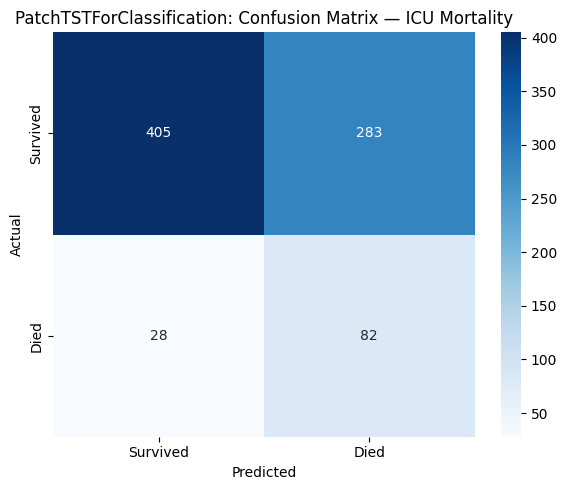

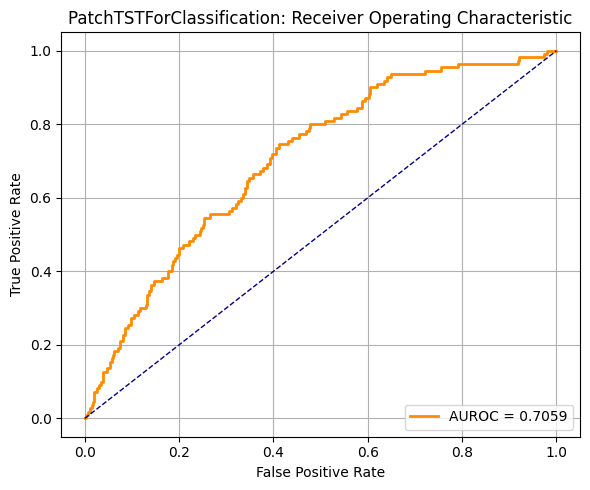

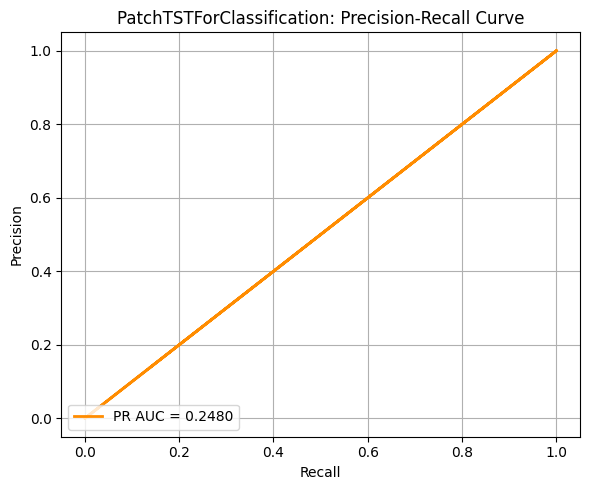

In [ ]:
# Load the best model
best_model_trainer = PatchTST_Trainer()
best_model_trainer.load_model(patchTST_bm_save_path)

# Load the checkpoint to get the best trial's parameters
best_trial = study.best_trial
bm_patch_len = best_trial.user_attrs["patch_len"]
bm_stride = best_trial.user_attrs["stride"]
bm_batch_size = best_trial.user_attrs["batch_size"]

# Evaluate the best model on the test set
bm_test_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, attention_mask=None, patch_length=bm_patch_len, stride=bm_stride), batch_size=bm_batch_size, shuffle=False)
bm_test_preds, bm_test_targets = best_model_trainer.evaluate(bm_test_loader)

# Display AUROC metric
print(f"Test AUROC: {best_model_trainer.calculate_auroc(bm_test_preds, bm_test_targets):.4f}\n")

# Classification report
best_model_trainer.classification_report(bm_test_preds, bm_test_targets)

# Plot confusion matrix
best_model_trainer.plot_confusion_matrix(bm_test_preds, bm_test_targets)

# Plot ROC curve
best_model_trainer.plot_roc_curve(bm_test_preds, bm_test_targets)

# Plot PR curve
best_model_trainer.plot_pr_curve(bm_test_preds, bm_test_targets)

### 8.3 Model Interpretation Using SHAP

This section uses the SHAP library to interpret the best model's predictions. It creates a wrapper around the PyTorch model to make it compatible with SHAP, then uses shap.DeepExplainer to calculate SHAP values for a subset of the test data. Finally, it aggregates these values across time steps and generates a summary plot to visualize feature importance and impact on the mortality prediction.

The SHAP analysis reveals that the best model prioritizes dynamic physiological features like Respiratory Rate, Binned Glasgow Coma Scale, and Binned Heart Rate as the strongest indicators of in-hospital mortality in the ICU. High values for these features significantly increase the predicted risk of death, aligning with clinical understanding of critical illness. Conversely, static demographic features such as Gender and ICU Type have a much smaller impact on the model's predictions compared to the real-time patient data. This indicates the model effectively leverages the time-series nature of the data to identify critical risk factors.

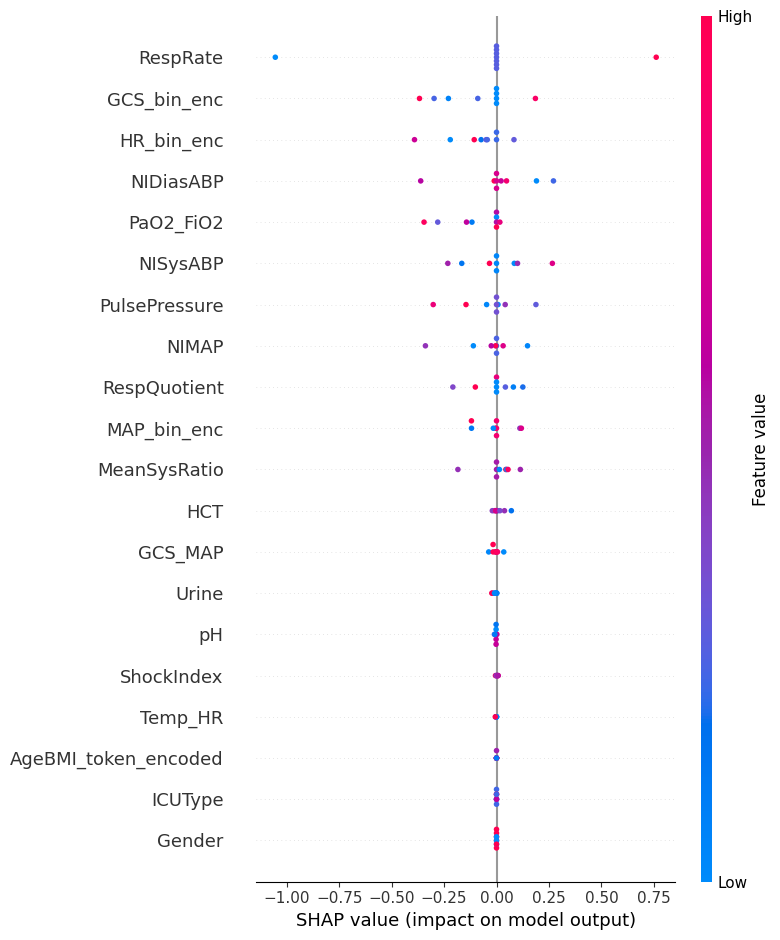

In [ ]:
best_model = best_model_trainer.model
best_model.eval()

# Pick a few samples for background and explanation
X_background = torch.tensor(X_test[:20], dtype=torch.float32)
X_explain = torch.tensor(X_test[21:30], dtype=torch.float32)

# Define a model wrapper that includes the patching logic
class PatchedModelWrapper(torch.nn.Module):
    def __init__(self, model, patch_length, stride):
        super().__init__()
        self.model = model
        self.patch_len = patch_length
        self.stride = stride

    def forward(self, x): # x has shape (batch, timesteps, features)
        all_patches = []
        for i in range(x.shape[0]):
            patient_series = x[i]
            data_patches = []
            for start in range(0, patient_series.shape[0] - self.patch_len + 1, self.stride):
                end = start + self.patch_len
                patch = patient_series[start:end]
                data_patches.append(patch.flatten())
            all_patches.append(torch.stack(data_patches))

        patched_x = torch.stack(all_patches)

        # Return the logits from the model
        return self.model(past_values=patched_x).prediction_logits

# Wrap the model
wrapped_model = PatchedModelWrapper(best_model, bm_patch_len, bm_stride)
wrapped_model.eval()

# Use DeepExplainer: It works by comparing the predictions on a background dataset to the predictions on the data to be explained.
explainer = shap.DeepExplainer(wrapped_model, X_background)

# Calculate SHAP values for the explanation data
# check_additivity=False is used to speed up computation, but it's recommended to set it to True for verification if time allows.
shap_values = explainer.shap_values(X_explain, check_additivity=False)

# shap_values has shape (samples, timesteps, features, classes)
# We select the SHAP values for class 1 (died)
shap_values_class1 = shap_values[:, :, :, 1]

# For the summary plot, we need to aggregate the SHAP values and features over the timesteps.
# A common way is to take the mean.
shap_values_agg = np.mean(shap_values_class1, axis=1) # Average over timesteps
X_explain_agg = np.mean(X_explain.numpy(), axis=1)      # Average over timesteps

# Create feature names
feature_names = [col for col in final_combined_df.columns if col not in ['RecordID', 'TimeBin', 'In-hospital_death']]

# Generate the SHAP summary plot
shap.summary_plot(shap_values_agg, X_explain_agg, feature_names=feature_names, show=True)

## 9. Compare Model Evaluations

This section compares the performance of the three models that were trained and evaluated in this notebook: the baseline model, the custom-configured model, and the best model found by Optuna. It first defines a function to get the evaluation metrics for a given model and then calls this function for each of the three models. The evaluation metrics are then stored in a Pandas DataFrame, which is then plotted to provide a visual comparison of the models' performance.

**Interpretation of the model comparison:**

*   **AUROC:** The "Best Model (Optuna)" has the highest AUROC, indicating it's the best at distinguishing between the "survived" and "died" classes. The "Custom Configuration" model is a close second, and both are significant improvements over the "Baseline" model.
*   **Accuracy:** The "Custom Configuration" model has the highest accuracy, meaning it predicts the correct class most often. The "Best Model (Optuna)" has a lower accuracy than the "Custom Configuration" model, but it's still an improvement over the "Baseline" model.
*   **Precision (died):** All models struggle with precision for the "died" class, with the "Custom Configuration" model performing the best, although still at a low 29%. This indicates that all models have a high number of false positives for the "died" class.
*   **Recall (died):** The "Best Model (Optuna)" has the highest recall for the "died" class, meaning it's the best at identifying patients who are at high risk of dying. The "Baseline" model is a close second, and the "Custom Configuration" model is the worst.
*   **F1-score (died):** The "Custom Configuration" model has the highest F1-score for the "died" class, indicating the best balance between precision and recall for this class.

**Overall:**

*   The **"Custom Configuration"** model appears to be the best overall model, with the highest accuracy and the best F1-score for the "died" class.
*   The **"Best Model (Optuna)"** is the best at identifying patients who are at high risk of dying (highest recall for the "died" class), but it has a lower accuracy and a higher number of false positives than the "Custom Configuration" model.
*   The **"Baseline"** model is the worst-performing model across most metrics.

In selecting the most suitable model for ICU mortality prediction, the specific clinical objective plays a decisive role. While the "Custom Configuration" model offers the highest overall accuracy, its relatively lower recall for the "died" class raises concerns about missing high-risk patients. On the other hand, the "Best Model (Optuna)" excels in identifying patients at elevated risk of death, due to its superior recall for the mortality class. In a medical context, where timely intervention is paramount, prioritizing the identification of critically ill patients even at the cost of increased false positives holds greater practical value. Therefore, considering the goal of accurately flagging patients who may require urgent care, the "Best Model (Optuna)" stands out as the most appropriate choice for this task.

In [ ]:
# Function to get evaluation metrics
def get_evaluation_metrics(trainer, test_loader):
    preds, targets = trainer.evaluate(test_loader)
    auroc = trainer.calculate_auroc(preds, targets)

    # Get classification report as a dictionary
    optimal_threshold = trainer.calculate_optimal_threshold(preds, targets)
    binary_preds = [1 if p >= optimal_threshold else 0 for p in preds]
    report = classification_report(targets, binary_preds, output_dict=True)

    return {
        "AUROC": auroc,
        "Accuracy": report["accuracy"],
        "Precision (survived)": report["0"]["precision"],
        "Precision (died)": report["1"]["precision"],
        "Recall (survived)": report["0"]["recall"],
        "Recall (died)": report["1"]["recall"],
        "F1-score (survived)": report["0"]["f1-score"],
        "F1-score (died)": report["1"]["f1-score"],
    }

# Load the baseline model
baseline_trainer = PatchTST_Trainer()
baseline_trainer.load_model(patchTST_save_path)
baseline_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, patch_length=patch_len, stride=stride), batch_size=batch_size, shuffle=False)
baseline_metrics = get_evaluation_metrics(baseline_trainer, baseline_loader)

# Load the fine-tuned model
fine_tuned_trainer = PatchTST_Trainer()
fine_tuned_trainer.load_model(patchTST_ft_save_path)
fine_tuned_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, patch_length=patch_len, stride=stride), batch_size=batch_size, shuffle=False)
fine_tuned_metrics = get_evaluation_metrics(fine_tuned_trainer, fine_tuned_loader)

# Load the best model from Optuna
best_model_trainer = PatchTST_Trainer()
best_model_trainer.load_model(patchTST_bm_save_path)
bm_checkpoint = torch.load(patchTST_bm_save_path, weights_only=False)
bm_best_trial = bm_checkpoint['best_trial']
bm_patch_len = bm_best_trial.user_attrs["patch_len"]
bm_stride = bm_best_trial.user_attrs["stride"]
bm_batch_size = bm_best_trial.user_attrs["batch_size"]
bm_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test, patch_length=bm_patch_len, stride=bm_stride), batch_size=bm_batch_size, shuffle=False)
bm_metrics = get_evaluation_metrics(best_model_trainer, bm_loader)

# Create a DataFrame to compare the results
comparison_df = pd.DataFrame([baseline_metrics, fine_tuned_metrics, bm_metrics], index=["Baseline", "Custom Configuration", "Best Model (Optuna)"])
display(comparison_df)

,AUROC,Accuracy,Precision (survived),Precision (died),Recall (survived),Recall (died),F1-score (survived),F1-score (died)
Baseline,0.629545,0.533835,0.922460,0.191038,0.501453,0.736364,0.649718,0.303371
Custom Configuration,0.699716,0.738095,0.926916,0.291139,0.755814,0.627273,0.832666,0.397695
Best Model (Optuna),0.705854,0.610276,0.935335,0.224658,0.588663,0.745455,0.722569,0.345263


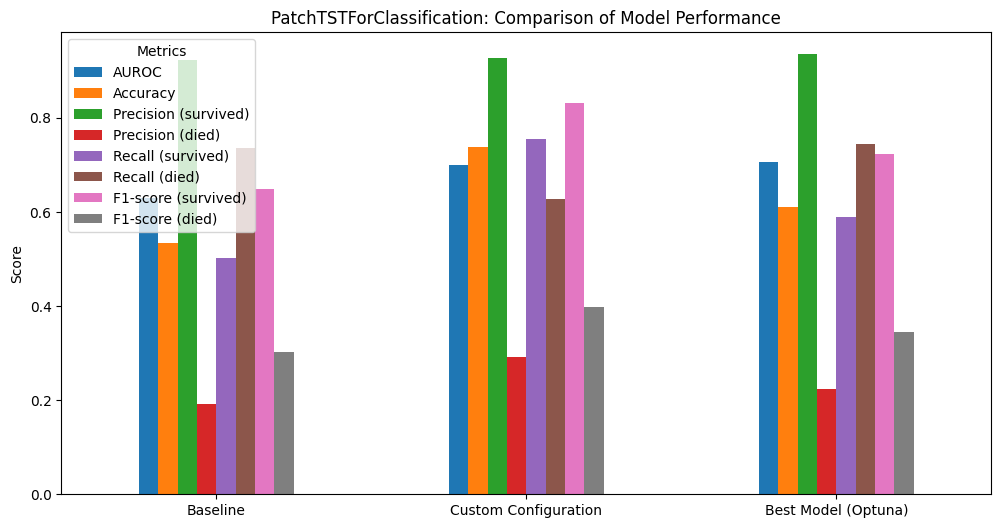

In [ ]:
# Plot the comparison of the evaluation metrics
comparison_df.plot(kind="bar", figsize=(12, 6))
plt.title("PatchTSTForClassification: Comparison of Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

## References:

Nie, Y., Nguyen, N., Sinthong, P., & Kalagnanam, J. (2023). *A TIME SERIES IS WORTH 64 WORDS: LONG-TERM FORECASTING WITH TRANSFORMERS*. https://arxiv.org/pdf/2211.14730

PyTorch Contributors. (2022, July 20). *Building Models with PyTorch*. Pytorch.org. https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

